In [9]:
import sys
import os
workspace_path = os.path.join(os.path.abspath(".."))
sys.path.append(workspace_path)
workspace_path

'c:\\Code\\job_discrimination'

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import glob
import re
import warnings
warnings.simplefilter("ignore")
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split, cross_val_score, ShuffleSplit
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree, preprocessing
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from pandas.core.frame import DataFrame

In [11]:
pd.options.display.float_format = "{:.2f}".format

In [12]:
# Reading application statistics into dataframe
filepath = os.path.join(workspace_path, "data", "cleaned_data", "applicants.csv")
df = pd.read_csv(filepath)
df


,ID,Job Description,Apps Received,Female,Male,Unknown_Gender,File Names
0,9206,311 DIRECTOR,54,20,31,3,311 DIRECTOR 9206 041814.txt
1,1223,ACCOUNTING CLERK,648,488,152,8,ACCOUNTING CLERK 1223 071318.txt
2,7260,AIRPORT MANAGER,51,13,37,1,AIRPORT MANAGER 7260 120216.txt
3,3227,AIRPORT POLICE LIEUTENANT,48,9,38,1,AIRPORT POLICE LIEUTENANT 3227 091616.txt
4,2400,AQUARIST,40,15,24,1,AQUARIST 2400 050214.txt
...,...,...,...,...,...,...,...
172,7840,WASTEWATER TREATMENT LABORATORY MANAGER,16,6,9,1,WASTEWATER TREATMENT LABORATORY MANAGER 7840 1...
173,4123,WASTEWATER TREATMENT OPERATOR,125,9,113,3,WASTEWATER TREATMENT OPERATOR 120718.txt
174,7857,WATER MICROBIOLOGIST,179,89,82,8,WATER MICROBIOLOGIST 7857 072514 rev073114.txt
175,3912,WATER UTILITY WORKER,96,2,92,2,WATER UTILITY WORKER 3912 120817.txt


In [ ]:
# Stripping job descriptions in dataframe from unnecessary parts
job_descriptions_stripped = []
for index, job in df["Job Description"].items():
    try:
        job = re.split(r'(^[^\d]+)', job)[1]
        job = job.replace("(", "")
        job = job.replace("-", "")
        job = job.replace("'", "")
        job = job.strip()
    except IndexError:
        pass
    
    job_descriptions_stripped.append(job.upper())

len(job_descriptions_stripped)

177

In [ ]:
# Replacing job descriptions in dataframe with stripped versions
df["Job Description"] = job_descriptions_stripped
df 

,ID,Job Description,Apps Received,Female,Male,Unknown_Gender,File Names
0,9206,311 DIRECTOR,54,20,31,3,311 DIRECTOR 9206 041814.txt
1,1223,ACCOUNTING CLERK,648,488,152,8,ACCOUNTING CLERK 1223 071318.txt
2,7260,AIRPORT MANAGER,51,13,37,1,AIRPORT MANAGER 7260 120216.txt
3,3227,AIRPORT POLICE LIEUTENANT,48,9,38,1,AIRPORT POLICE LIEUTENANT 3227 091616.txt
4,2400,AQUARIST,40,15,24,1,AQUARIST 2400 050214.txt
...,...,...,...,...,...,...,...
172,7840,WASTEWATER TREATMENT LABORATORY MANAGER,16,6,9,1,WASTEWATER TREATMENT LABORATORY MANAGER 7840 1...
173,4123,WASTEWATER TREATMENT OPERATOR,125,9,113,3,WASTEWATER TREATMENT OPERATOR 120718.txt
174,7857,WATER MICROBIOLOGIST,179,89,82,8,WATER MICROBIOLOGIST 7857 072514 rev073114.txt
175,3912,WATER UTILITY WORKER,96,2,92,2,WATER UTILITY WORKER 3912 120817.txt


In [ ]:
# Fetching file names for job bulletins in folder with labeled bulletins
# Creating one list with full file names and one with stripped file names
labeled_bulletins = []
stripped_labeled_bulletins = []
filepath = os.path.join(workspace_path, "data", "cleaned_data", "Job_Bulletins", "labeled")
for bulletin in os.listdir(filepath):
    try:
        stripped = re.split(r'(^[^\d]+)', bulletin)[1]
        stripped = stripped.replace("(", "")
        stripped = stripped.replace("-", "")
        stripped = stripped.replace("_", "")
        stripped = stripped.strip()
        stripped = stripped.upper()
        if stripped in job_descriptions_stripped:
            labeled_bulletins.append(bulletin)
            stripped_labeled_bulletins.append(stripped)
        elif stripped == "SENIOR ELECTRICAL TEST TECHNICIAN" or stripped == "WORKERS COMPENSATION CLAIMS ASSISTANT":
            labeled_bulletins.append(bulletin)
            stripped_labeled_bulletins.append(stripped)
    except IndexError:
        pass

In [ ]:
# Creating a look up-dict to go from stripped file names to full file names
dict_text = dict(zip(stripped_labeled_bulletins, labeled_bulletins))

In [ ]:
# Getting full file names into dataframe
file_names = [dict_text.get(value, None) for index, value in df["Job Description"].items()]
df["File Names"] = file_names

In [ ]:
df

,ID,Job Description,Apps Received,Female,Male,Unknown_Gender,File Names
0,9206,311 DIRECTOR,54,20,31,3,None
1,1223,ACCOUNTING CLERK,648,488,152,8,ACCOUNTING CLERK 1223
2,7260,AIRPORT MANAGER,51,13,37,1,AIRPORT MANAGER 7260
3,3227,AIRPORT POLICE LIEUTENANT,48,9,38,1,AIRPORT POLICE LIEUTENANT 3227
4,2400,AQUARIST,40,15,24,1,AQUARIST 2400
...,...,...,...,...,...,...,...
172,7840,WASTEWATER TREATMENT LABORATORY MANAGER,16,6,9,1,WASTEWATER TREATMENT LABORATORY MANAGER 7840
173,4123,WASTEWATER TREATMENT OPERATOR,125,9,113,3,WASTEWATER TREATMENT OPERATOR 4123
174,7857,WATER MICROBIOLOGIST,179,89,82,8,WATER MICROBIOLOGIST 7857
175,3912,WATER UTILITY WORKER,96,2,92,2,WATER UTILITY WORKER 3912


In [ ]:
# Getting content from job bulletin files and putting it into dataframe
contents = []
for index, value in df["File Names"].items():
    if value == None:
        content = None
    else:
        file_path = os.path.join(workspace_path, "data", "cleaned_data", "Job_Bulletins","labeled", value)
        with open(file_path) as f:
            # Remove newlines
            content = f.read().replace("\n", " ")
            # Remove numbers
            content = re.sub("\d", "", content)
    contents.append(content)
df["Content"] = contents
df

,ID,Job Description,Apps Received,Female,Male,Unknown_Gender,File Names,Content
0,9206,311 DIRECTOR,54,20,31,3,None,None
1,1223,ACCOUNTING CLERK,648,488,152,8,ACCOUNTING CLERK 1223,ACCOUNTING CLERK Class Code: Open Date...
2,7260,AIRPORT MANAGER,51,13,37,1,AIRPORT MANAGER 7260,AIRPORT MANAGER Class Code: Open Date:...
3,3227,AIRPORT POLICE LIEUTENANT,48,9,38,1,AIRPORT POLICE LIEUTENANT 3227,AIRPORT POLICE LIEUTENANT ...
4,2400,AQUARIST,40,15,24,1,AQUARIST 2400,AQUARIST Class Code: Open Date: -- ANN...
...,...,...,...,...,...,...,...,...
172,7840,WASTEWATER TREATMENT LABORATORY MANAGER,16,6,9,1,WASTEWATER TREATMENT LABORATORY MANAGER 7840,WASTEWATER TREATMENT LABORATORY MANAGER Class...
173,4123,WASTEWATER TREATMENT OPERATOR,125,9,113,3,WASTEWATER TREATMENT OPERATOR 4123,WASTEWATER TREATMENT OPERATOR Class Code: ...
174,7857,WATER MICROBIOLOGIST,179,89,82,8,WATER MICROBIOLOGIST 7857,WATER MICROBIOLOGIST Class Code: Ope...
175,3912,WATER UTILITY WORKER,96,2,92,2,WATER UTILITY WORKER 3912,WATER UTILITY WORKER Class Code: Open D...


In [ ]:
# Create and add labels
mostly_women = df["Female"] >= (df["Apps Received"] - df["Unknown_Gender"]) * 0.6
mostly_men = df["Male"] >= (df["Apps Received"] - df["Unknown_Gender"]) * 0.6
neutral = (df["Female"] < (df["Apps Received"] - df["Unknown_Gender"]) * 0.6) & (df["Female"] > (df["Apps Received"] - df["Unknown_Gender"]) * 0.4)

In [ ]:
labels = []
for i in range(len(df)):
    if mostly_women[i]:
        label = "W"
    elif mostly_men[i]:
        label = "M"
    elif neutral[i]:
        label = "N"
    else:
        label = None
    labels.append(label)
df["Labels"] = labels


In [ ]:
df["Labels"].value_counts()

M    126
N     32
W     19
Name: Labels, dtype: int64

In [ ]:
df

,ID,Job Description,Apps Received,Female,Male,Unknown_Gender,File Names,Content,Labels
0,9206,311 DIRECTOR,54,20,31,3,None,None,M
1,1223,ACCOUNTING CLERK,648,488,152,8,ACCOUNTING CLERK 1223,ACCOUNTING CLERK Class Code: Open Date...,W
2,7260,AIRPORT MANAGER,51,13,37,1,AIRPORT MANAGER 7260,AIRPORT MANAGER Class Code: Open Date:...,M
3,3227,AIRPORT POLICE LIEUTENANT,48,9,38,1,AIRPORT POLICE LIEUTENANT 3227,AIRPORT POLICE LIEUTENANT ...,M
4,2400,AQUARIST,40,15,24,1,AQUARIST 2400,AQUARIST Class Code: Open Date: -- ANN...,M
...,...,...,...,...,...,...,...,...,...
172,7840,WASTEWATER TREATMENT LABORATORY MANAGER,16,6,9,1,WASTEWATER TREATMENT LABORATORY MANAGER 7840,WASTEWATER TREATMENT LABORATORY MANAGER Class...,M
173,4123,WASTEWATER TREATMENT OPERATOR,125,9,113,3,WASTEWATER TREATMENT OPERATOR 4123,WASTEWATER TREATMENT OPERATOR Class Code: ...,M
174,7857,WATER MICROBIOLOGIST,179,89,82,8,WATER MICROBIOLOGIST 7857,WATER MICROBIOLOGIST Class Code: Ope...,N
175,3912,WATER UTILITY WORKER,96,2,92,2,WATER UTILITY WORKER 3912,WATER UTILITY WORKER Class Code: Open D...,M


In [ ]:
df.isnull().sum()

ID                 0
Job Description    0
Apps Received      0
Female             0
Male               0
Unknown_Gender     0
File Names         1
Content            1
Labels             0
dtype: int64

In [ ]:
df.dropna(how="any", inplace=True)
df.reset_index(inplace=True, drop=True)
df.drop(columns=["Apps Received", "Female", "Male", "Unknown_Gender"], inplace=True)

In [ ]:
df

,ID,Job Description,File Names,Content,Labels
0,1223,ACCOUNTING CLERK,ACCOUNTING CLERK 1223,ACCOUNTING CLERK Class Code: Open Date...,W
1,7260,AIRPORT MANAGER,AIRPORT MANAGER 7260,AIRPORT MANAGER Class Code: Open Date:...,M
2,3227,AIRPORT POLICE LIEUTENANT,AIRPORT POLICE LIEUTENANT 3227,AIRPORT POLICE LIEUTENANT ...,M
3,2400,AQUARIST,AQUARIST 2400,AQUARIST Class Code: Open Date: -- ANN...,M
4,1191,ARCHIVIST,ARCHIVIST 1191,ARCHIVIST Class Code: Open Date: -- ...,N
...,...,...,...,...,...
171,7840,WASTEWATER TREATMENT LABORATORY MANAGER,WASTEWATER TREATMENT LABORATORY MANAGER 7840,WASTEWATER TREATMENT LABORATORY MANAGER Class...,M
172,4123,WASTEWATER TREATMENT OPERATOR,WASTEWATER TREATMENT OPERATOR 4123,WASTEWATER TREATMENT OPERATOR Class Code: ...,M
173,7857,WATER MICROBIOLOGIST,WATER MICROBIOLOGIST 7857,WATER MICROBIOLOGIST Class Code: Ope...,N
174,3912,WATER UTILITY WORKER,WATER UTILITY WORKER 3912,WATER UTILITY WORKER Class Code: Open D...,M


In [ ]:
X = df["Content"]
y = df["Labels"]

In [ ]:
vect = CountVectorizer(stop_words="english")

In [ ]:
X = vect.fit_transform(X).todense()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1000)

In [ ]:
model = DecisionTreeClassifier(criterion="entropy")

In [ ]:
model.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy')

In [ ]:
y_pred = model.predict(X_test)

In [ ]:
y_pred

array(['M', 'M', 'M', 'M', 'N', 'M', 'W', 'M', 'M', 'M', 'N', 'M', 'M',
       'W', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'N', 'M',
       'M', 'W', 'M', 'N', 'M', 'M', 'M', 'M', 'M', 'N', 'M', 'W', 'M',
       'M', 'M', 'N', 'M', 'W'], dtype=object)

In [ ]:
accuracy = accuracy_score(y_pred, y_test) * 100
print(f"Accuracy of the model is {'{:.2f}'.format(accuracy)}")

Accuracy of the model is 70.45


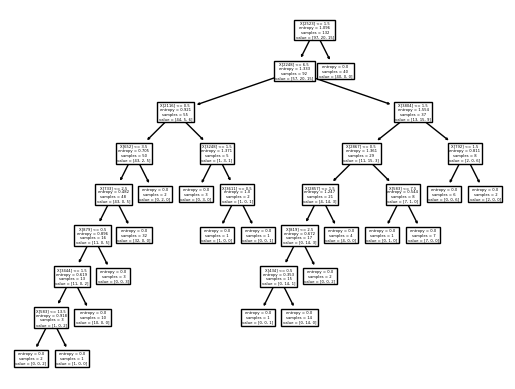

In [ ]:
tree.plot_tree(model)
plt.show()


In [ ]:
cm = confusion_matrix(y_true=y_test, y_pred=y_pred, labels=model.classes_)

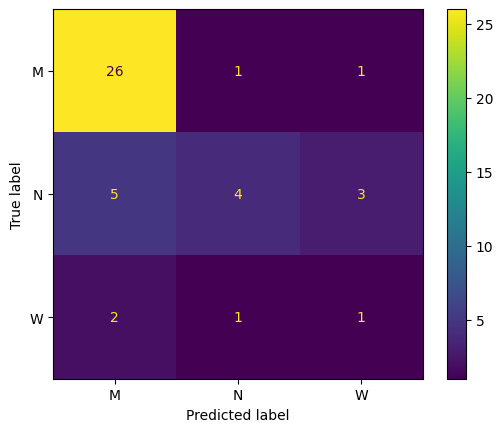

In [ ]:
plot = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
plot.plot()
plt.show()

In [ ]:
scores = cross_val_score(model, X, y, cv=5)
scores

array([0.66666667, 0.45714286, 0.77142857, 0.68571429, 0.65714286])

In [ ]:
# Standard deviation: The spread of values. 
# High standard deviation implies high spread of accuracies between cross-validation folds
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))


0.65 accuracy with a standard deviation of 0.10


In [ ]:
n_samples = X.shape[0]
cv = ShuffleSplit(n_splits=5, test_size=0.3, random_state=0)
other_scores = cross_val_score(model, X, y, cv=cv)
other_scores

array([0.67924528, 0.54716981, 0.67924528, 0.67924528, 0.69811321])

In [ ]:
print("%0.2f accuracy with a standard deviation of %0.2f" % (other_scores.mean(), other_scores.std()))

0.66 accuracy with a standard deviation of 0.06


In [35]:
model.score(X_test, y_test)

0.7045454545454546